In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
import urllib.request

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x219efd00a30>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
print('number of training data :', len(train_data))

number of training data : 150000


In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print('total number of sample :', len(train_data))

total number of sample : 146183


In [10]:
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]

id          0
document    1
label       0
dtype: int64


,id,document,label
25857,2172111,NaN,1


In [11]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [12]:
print('total number of sample :', len(train_data))
print()
print(train_data.groupby('label').size().reset_index(name = 'count'))

total number of sample : 146182

   label  count
0      0  73342
1      1  72840


In [15]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [16]:
train_data['document'] = train_data['document'].str.replace(" ", "")
train_data['document'].replace("", np.nan, inplace=True)
print(train_data.isnull().sum())
#공백 날라갔네 다

id            0
document    789
label         0
dtype: int64


In [17]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [18]:
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
test_data['document'] = test_data['document'].str.replace(" ", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any')
print('Final total number of test_data: ', len(test_data))

Final total number of test_data:  48852


In [19]:
from konlpy.tag import Okt
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [20]:
okt = Okt()
okt.morphs('와 이런 영화를 영화관에 내보냈네 차라리 뮤비를 만드는게 나을 것 같은데', stem=True)

['오다',
 '이렇다',
 '영화',
 '를',
 '영화관',
 '에',
 '내보내다',
 '차라리',
 '뮤비',
 '를',
 '만들다',
 '나다',
 '것',
 '같다']

In [21]:
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import FreqDist

from konlpy.tag import Mecab


In [22]:
tokenizer = Okt()

X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

In [23]:
print(X_train[:5])

[['아더', '빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '크다', '스틴던스트', '너무나도', '이쁘다', '보이다']]


In [24]:
X_test = []
for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [25]:
print(X_test[:5])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '만점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임돈', '주다', '보기', '에는'], ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로나', '서다', '제', '심기', '불편하다'], ['음악', '주가', '되다', '최고', '음악', '영화']]


In [26]:
vocab = FreqDist(np.hstack(X_train))
print('Size of Vocabulary : {}'.format(len(vocab)))
# np.hstack / vocab 어떻게 반환되는지 알아오기 -> FreqDist 뭐니

Size of Vocabulary : 46503


In [27]:
print('Frequency of 영화 : ', vocab['영화'])
print('Frequency of 재밌 : ', vocab['재밌'])

Frequency of 영화 :  44383
Frequency of 재밌 :  2


In [28]:
threshold = 3
total_cnt = len(vocab)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in vocab.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        

print('단어 집합의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s'%(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq/total_freq)*100)


단어 집합의 크기 : 46503
등장 빈도가 2번 이하인 희귀 단어의 수 : 25474
단어 집합에서 희귀 단어의 비율 :  54.77926155301809
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  1.9761734039734433


In [29]:
vocab_size = total_cnt - rare_cnt
vocab = vocab.most_common(vocab_size)
print('Size of Vocab : {}'.format(len(vocab)))

Size of Vocab : 21029


In [30]:
word_to_index = {word[0]: index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 1
word_to_index['unk'] = 0

In [31]:
encoded = []
for line in X_train: 
    temp = []
    for w in line:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['unk'])
            
    encoded.append(temp)

In [32]:
print(encoded[:10])

[[9880, 11448, 18, 250, 662], [1063, 469, 46, 606, 2, 408, 1510, 29, 1078, 681, 19], [215, 1720, 0, 570, 3849, 3, 227, 8], [6989, 107, 9325, 217, 66, 5, 24, 4090], [1131, 17649, 25, 9881, 29, 834, 2, 2691, 22, 1136, 284, 222, 13768, 1105, 243, 284], [988, 6740, 1106, 1394, 1752, 1667, 12519, 246, 2, 90, 131, 1155, 42, 248], [221, 307, 2424, 425, 511], [131, 1155, 42, 4168, 41, 11449, 15382, 29, 1687, 5550, 228, 11, 1014, 20, 540, 565, 567, 527, 3310, 8778, 17, 1529, 1529, 35, 285, 5, 29, 60, 10, 37, 17, 846, 1006, 52], [96, 5, 47, 449, 94, 2], [1771, 24, 202, 5255, 17, 347, 1559, 321, 667, 9, 5913]]


In [33]:
max_len = max(len(n) for n in encoded)
print('max length of Review : ', max_len)
print('min length of Review : ', min(len(n) for n in encoded))
print('average length of Review : ', (sum(map(len, encoded))/len(encoded)))

max length of Review :  68
min length of Review :  0
average length of Review :  10.95426877497541


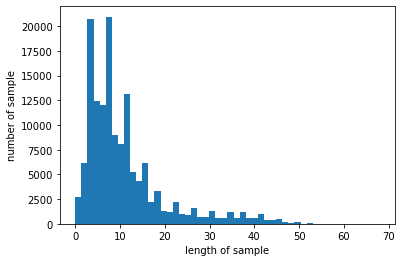

In [34]:
plt.hist([len(n) for n in encoded], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [35]:
for line in encoded:
    if len(line) < max_len:
        line += [word_to_index['pad']] * (max_len - len(line))

print('max length of Review : ', max_len)
print('min length of Review : ', min(len(n) for n in encoded))
print('average length of Review : ', (sum(map(len, encoded))/len(encoded)))

max length of Review :  68
min length of Review :  68
average length of Review :  68.0


In [270]:
print(encoded[:10])

[[9880, 11448, 18, 250, 662, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1063, 469, 46, 606, 2, 408, 1510, 29, 1078, 681, 19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [215, 1720, 0, 570, 3849, 3, 227, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [6989, 107, 9325, 217, 66, 5, 24, 4090, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1131, 17649, 25, 9881, 29, 834, 2, 2691, 22, 1136, 284, 222, 13768, 1105, 243, 284, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [271]:
import os
from torch.utils.data import DataLoader

In [331]:
torch_encoded = torch.Tensor(encoded)
batch_size = 64
train_dataloader = DataLoader(torch_encoded,batch_size=64)

Y_label = []
for l in test_data['label']:
    Y_label.append(l)
train_label = torch.Tensor(Y_label)
#train_labelloader = DataLoader(train_label, batch_size=64)

# 데이터로더 이름: train_dataloader

In [428]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                         num_layers=self.n_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
        
    
    def forward(self ,x):
        x = x.to(torch.int64)
        x = self.embed(x)
        h0 = self._init_state(batch_size=x.size(0))
        #h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).cuda()
        #뒤에 cuda 안 붙이면 input과 hidden tensor가 다른 device에 들어감
        x, _ = self.gru(x, h0)
        print(x.shape)
        ht = x[:,-1,:]
        #batch size, hidden state size 가져오기
        
        self.dropout(ht)
        logit = self.out(ht)
        #logit = torch.sigmoid(logit)
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
    #tensor를 zero로 만들려면 그냥 위에서 h0으로 생성

In [429]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [430]:
model = GRU(1, 256, vocab_size, 128, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [431]:
def train(model, optimizer, train_dataloader):
    model.train()
    for batch, label in zip(train_dataloader, Y_label):
        x, y = batch.to(device), torch.Tensor(label)
        optimizer.zero_grad()
    
        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [432]:
def evaluate(model, val_iter, y_label):
    model.eval()
    correct, total_loss = 0, 0
    for batch, label in zip(val_iter, Y_label):
        x, y = batch.to(device), torch.Tensor(label)
        
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        correct += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * correct / size*batch_size
    return avg_loss, avg_accuracy

In [433]:
train_loss = None
for e in range(1, 11):
    train(model, optimizer, train_dataloader)
    val_loss, val_accuracy = evaluate(model, train_dataloader, Y_label)
    
    print("[Epoch: %d] loss: %7.4f | accuracy: %7.4f" %(e, val_loss, val_accuracy))

torch.Size([64, 68, 256])


ValueError: Expected input batch_size (64) to match target batch_size (1).